In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

# **1. DATA UNDERSTANDING**

## 1.2 INITIAL DATA COLLECTION AND FAMILIARIZATION

In [4]:
# Load the dataset

dataset=pd.read_csv(r'C:\Users\jlwon\OneDrive\Desktop\Clustering\Wholesale customers data.csv')


In [5]:
# Display first five samples

dataset.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [6]:
# Display last five samples

dataset.tail()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125
439,1,3,2787,1698,2510,65,477,52


In [7]:
# Display columns and data types information

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [8]:
# Display summary of statistics

dataset.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


## 1.2 IDENTIFY DATA QUALITY ISSUES

In [10]:
# Explore unique value in categorical variables

# Select categorical columns
categorical_columns = ['Channel', 'Region']

# Display unique values for categorical columns
for col in categorical_columns:
    print(f"Unique values for {col}: {dataset[col].unique()}")


Unique values for Channel: [2 1]
Unique values for Region: [3 1 2]


In [11]:
# Explore duplicates

# Check for duplicates
print(f"Number of duplicates: {dataset.duplicated().sum()}")

Number of duplicates: 0


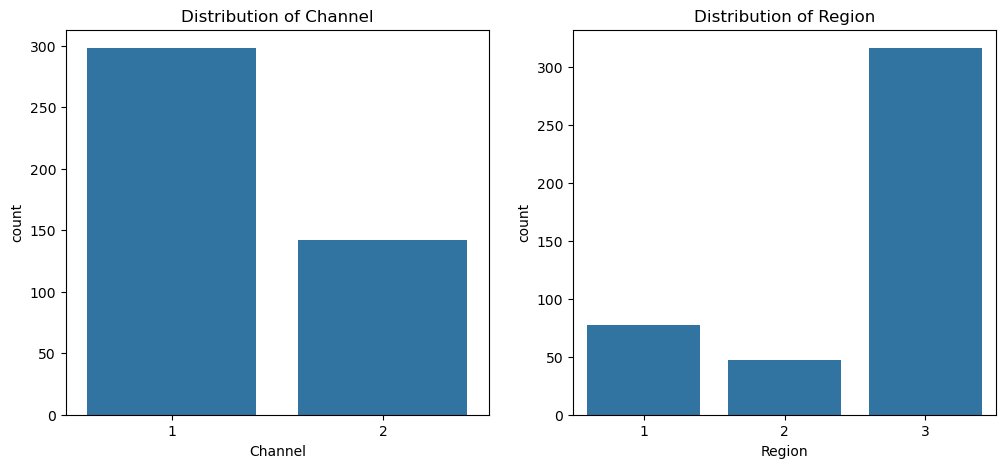

In [12]:
# Display distribution of categorical features

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=dataset, x='Channel')
plt.title('Distribution of Channel')

plt.subplot(1, 2, 2)
sns.countplot(data=dataset, x='Region')
plt.title('Distribution of Region')

plt.show()

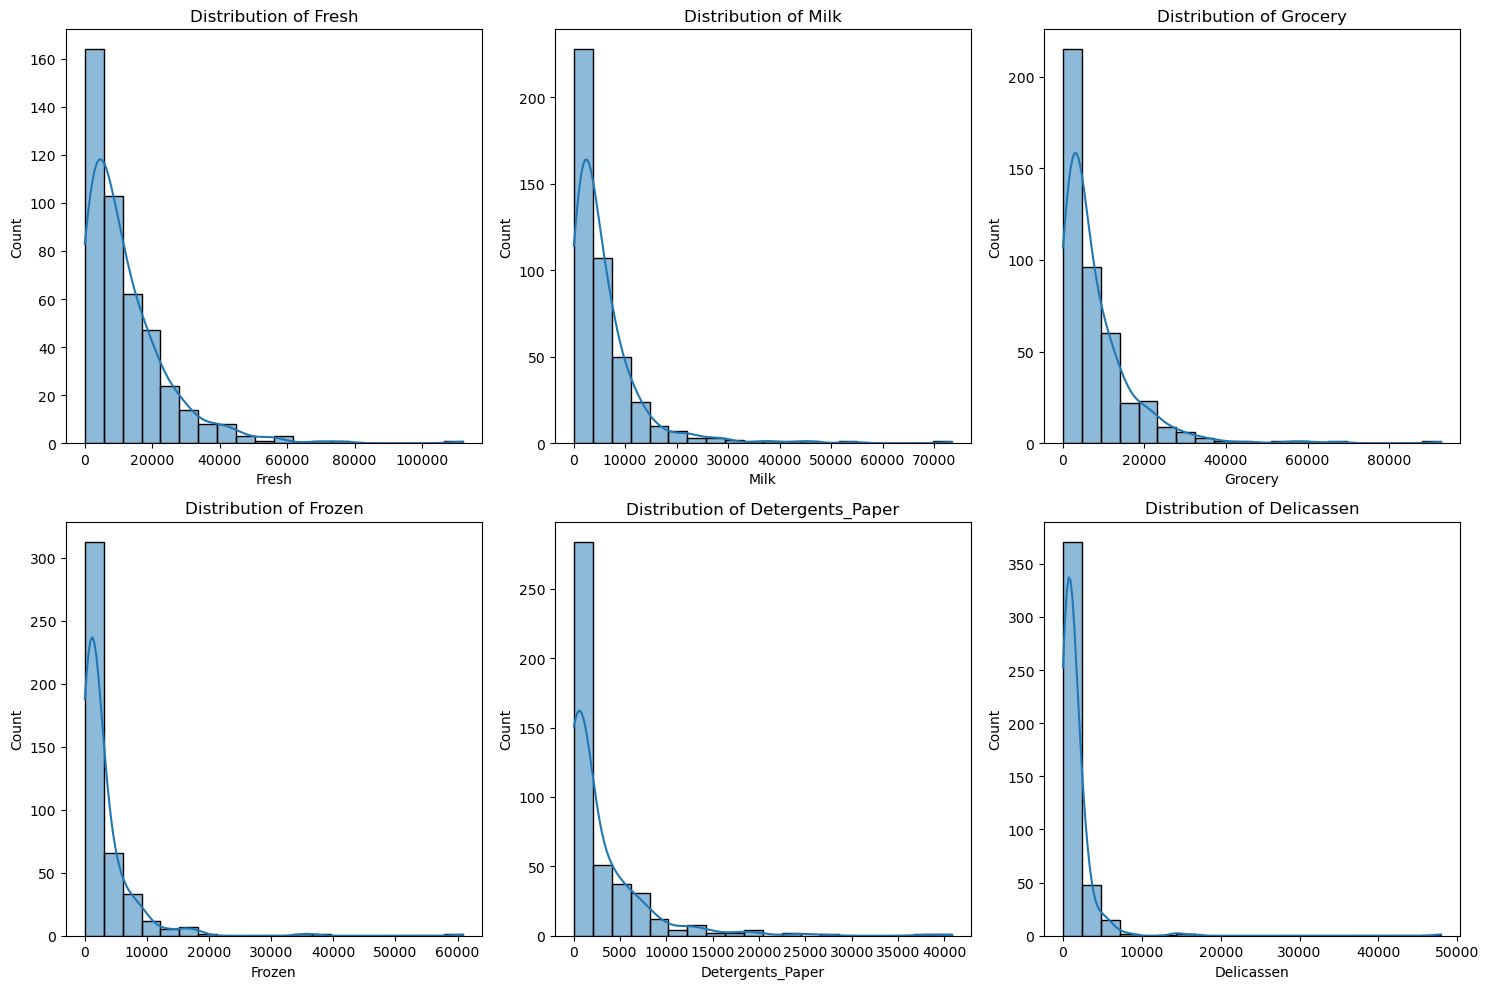

In [13]:
# Display distribution of quantitative continuous variables

continuous_features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(continuous_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(dataset[feature], bins=20, kde=True)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

In [14]:
# Explore skewness (asymmetry) in the distribution

for feature in continuous_features:
    # The skew function in scipy.stats calculates skewness using the Fisher-Pearson standardized moment coefficient formula (measures the asymmetry of the distribution of values around the mean)
    skewness = skew(dataset[feature])
    print(f'Skewness of {feature}: {skewness:.2f}')

Skewness of Fresh: 2.55
Skewness of Milk: 4.04
Skewness of Grocery: 3.58
Skewness of Frozen: 5.89
Skewness of Detergents_Paper: 3.62
Skewness of Delicassen: 11.11


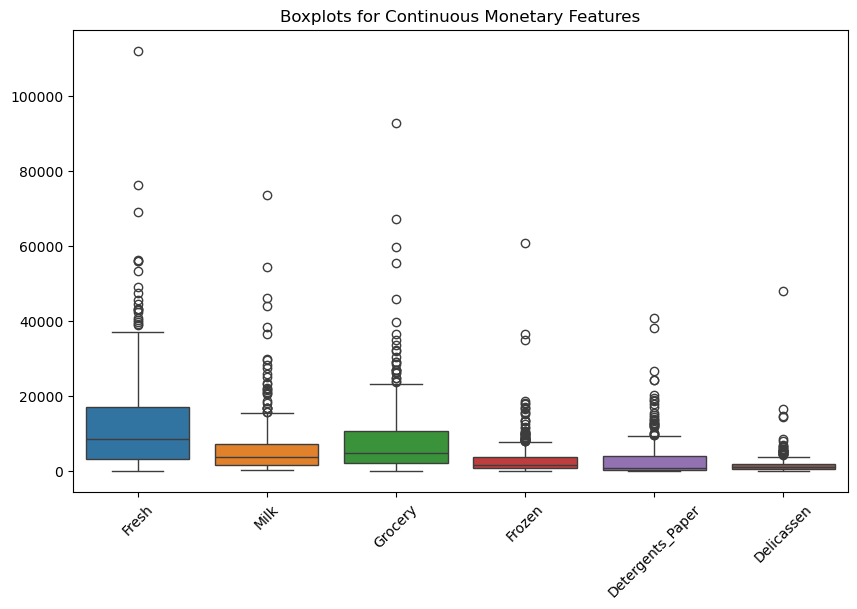

In [15]:
# Explore variablitiy of continuous features

plt.figure(figsize=(10, 6))
sns.boxplot(data=dataset[continuous_features])
plt.title("Boxplots for Continuous Monetary Features")
plt.xticks(rotation=45)
plt.show()

## 1.3 INITIAL OBVIOUS RESULTS

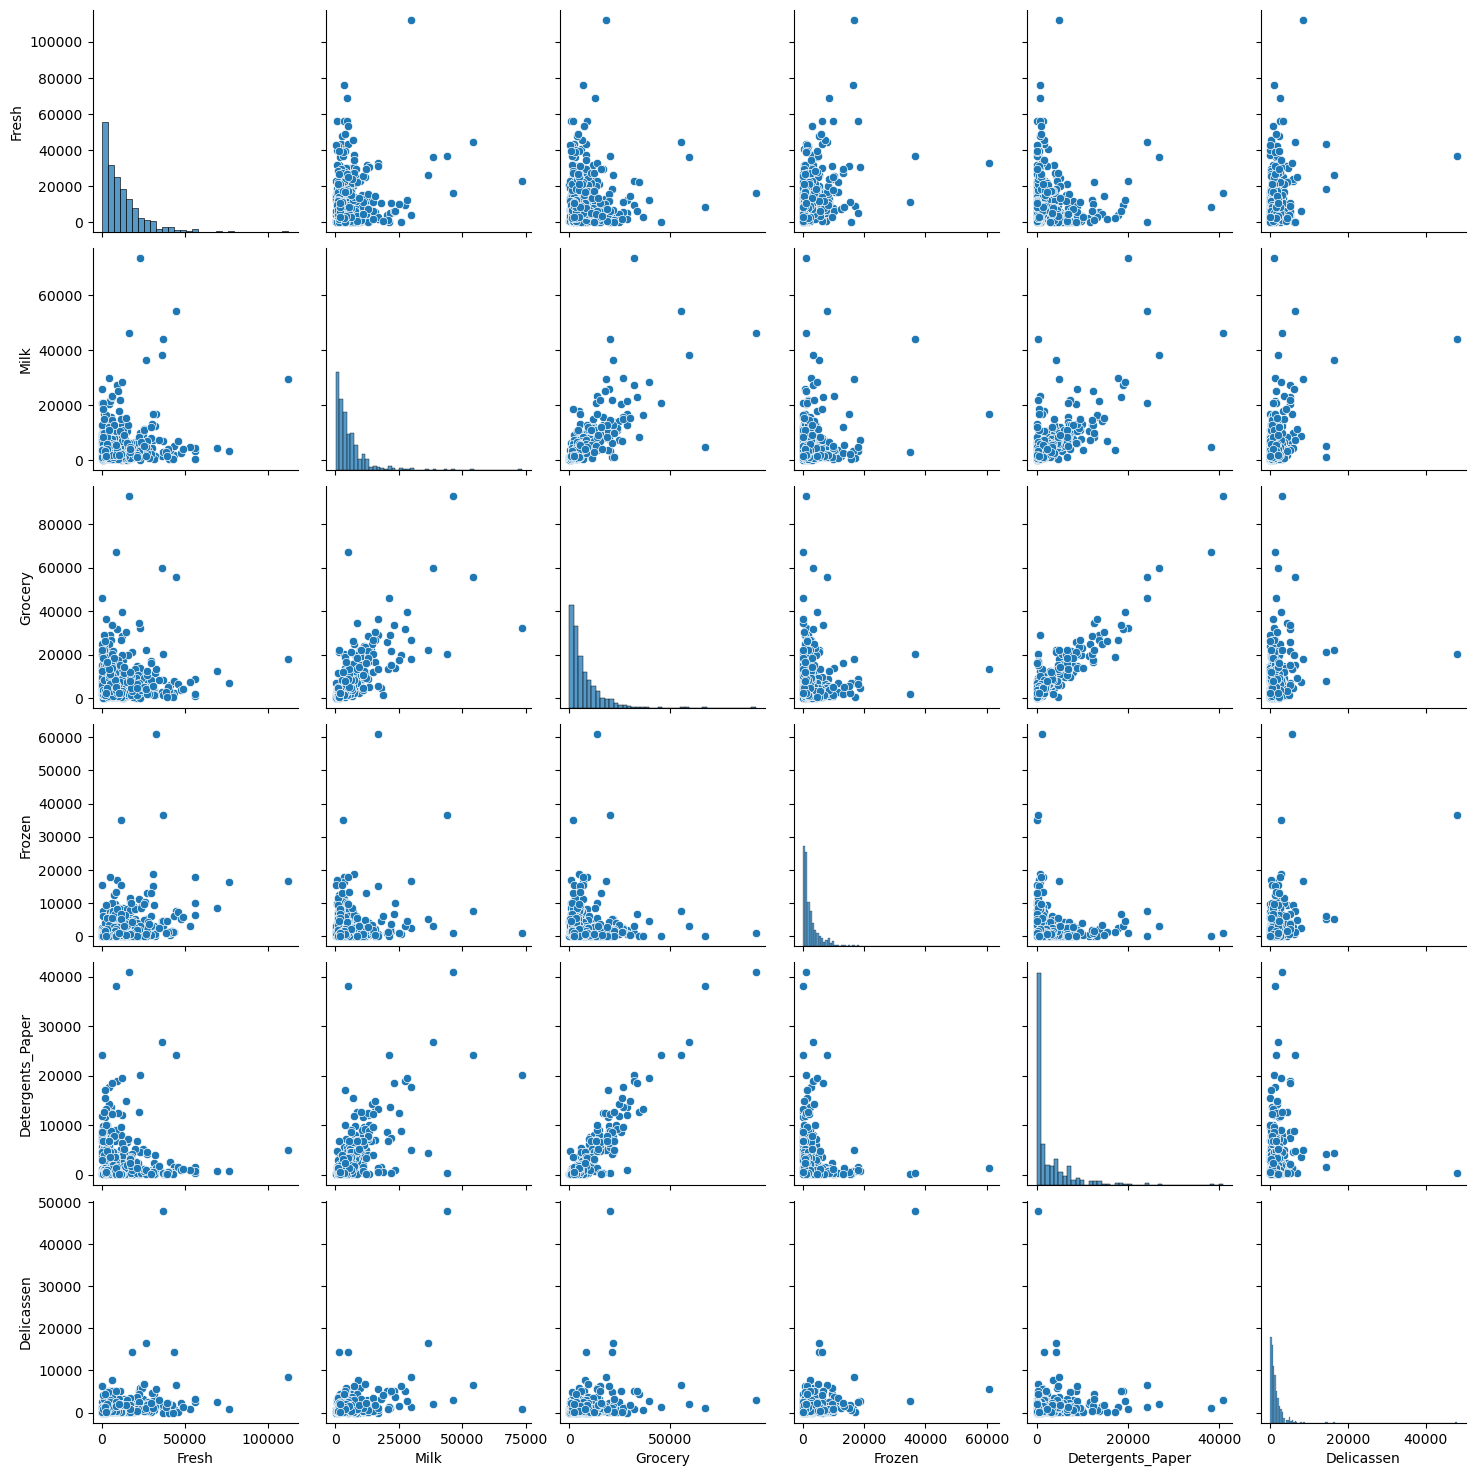

In [17]:
# Explore relations between features

sns.pairplot(dataset.iloc[:,[2,3,4,5,6,7]])

# **2. DATA PREPARATION**

In [19]:
# Address outliers  to prevent them from distorting the analysis (minimises the impact of extreme values which is important for distance based algorithms)

# Uses the IQR method to address outliers by capping them at the lower and upper bounds defined by the IQR
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

# Apply the function to each continuous feature
for feature in continuous_features:
    cap_outliers(dataset, feature)

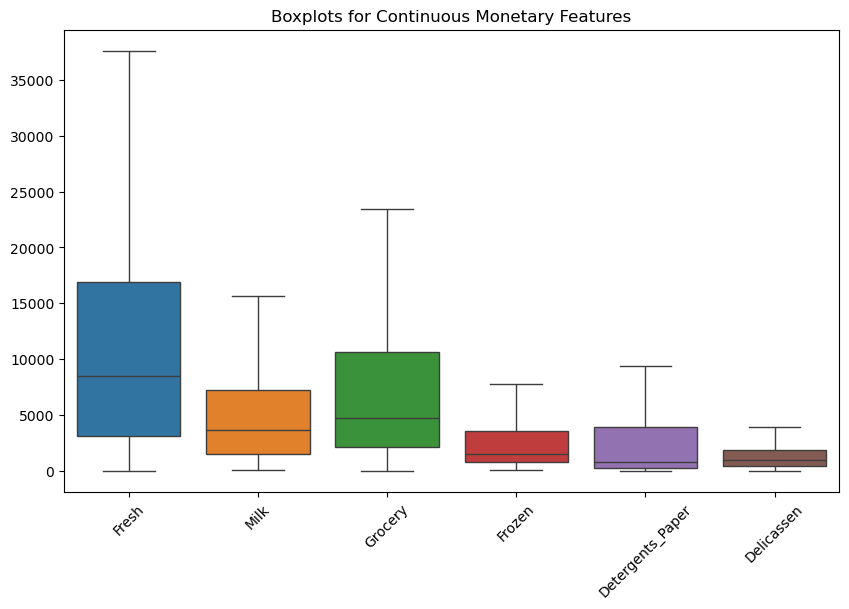

In [20]:
# Explore variablitiy of continuous numerical features after capping

plt.figure(figsize=(10, 6))
sns.boxplot(data=dataset[continuous_features])
plt.title("Boxplots for Continuous Monetary Features")
plt.xticks(rotation=45)
plt.show()

In [21]:
# address skewness to make the dataset more symmetric

#Log transform to reduce skewness (replaces each value in the dataset with its logarithm)
for feature in continuous_features:
    dataset[feature] = np.log1p(dataset[feature])

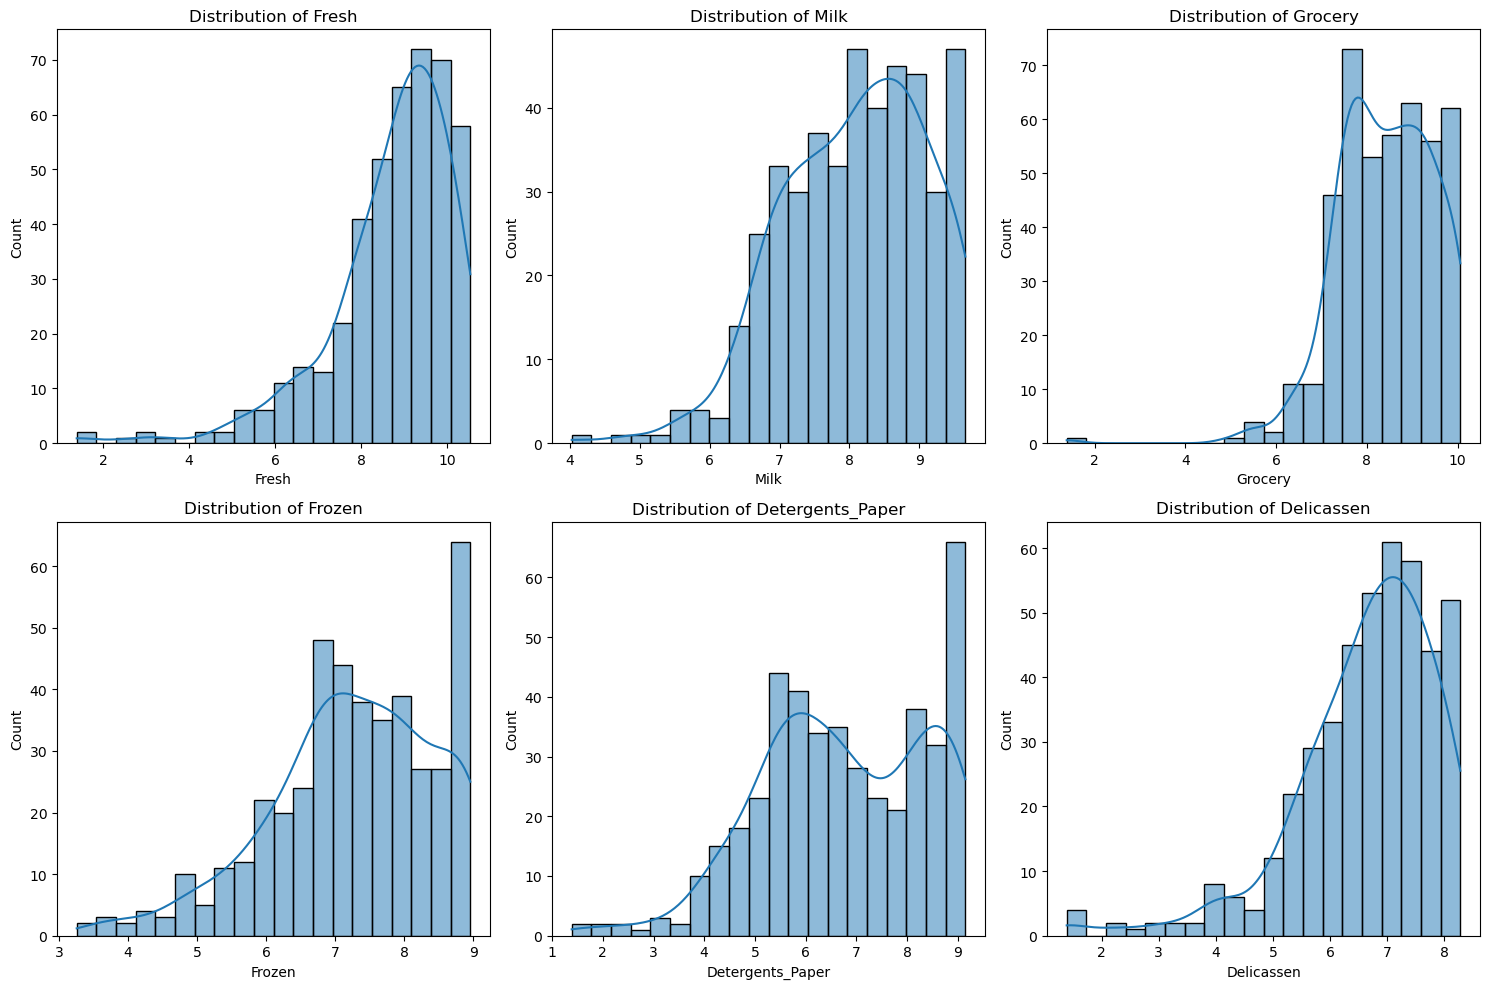

In [22]:
# Distribution of quantitative continuous variables aftr log transformation

continuous_features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(continuous_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(dataset[feature], bins=20, kde=True)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

In [23]:
# Standardise the features (Z-Score Scaling) transforms the data to have a mean of 0 and a standard deviation of 1 
# which centers the data around zero and removes any units of measurement.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dataset[continuous_features] = scaler.fit_transform(dataset[continuous_features])


In [24]:
# Display sample of the data after standardisation

dataset.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,0.500984,1.058910,0.474133,-1.563373,0.685479,0.451971
1,2,3,0.097739,1.074366,0.693422,0.176359,0.811403,0.680391
2,2,3,0.025318,0.969118,0.489164,0.433457,0.851031,1.322916
3,1,3,0.532666,-0.980853,-0.068820,1.243004,-0.319493,0.685823
4,2,3,0.900332,0.493006,0.428305,0.836203,0.438377,1.322916


In [25]:
# Since the channel and region features are already numerical (although being categorical) there is no need to encode them

# **3. MODELING**

#  3.1 K-MEANS MODEL

C:\Users\jlwon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\jlwon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\jlwon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\jlwon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

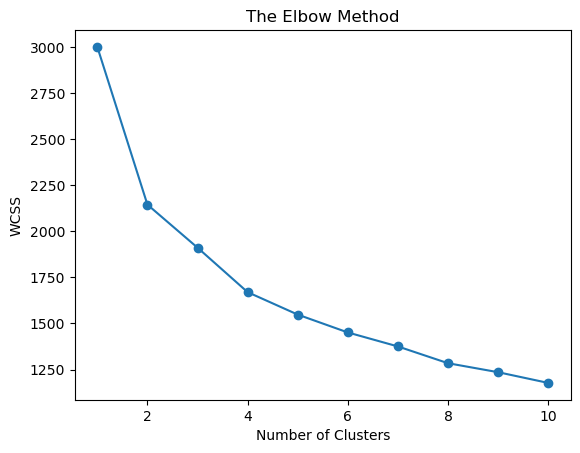

In [28]:
# Elbow method to find the best number of clusters

# Initialise an empty list for WCSS (within-cluster sum of squares)
# WCSS measure the compactness of clusters by calculating the sum of squared distances from each point to its cluster’s centroid
wcss = []

# Loop through a range of cluster numbers from 1 to 10
for i in range(1, 11):
    # Create a KMeans model with the current number of clusters
    #Traditional KMeans selects centroids randomly, then iteratively updates them based on the mean distance of points within each cluster.
    #KMeans++ improves this by using a probabilistic approach to select initial centroids, giving points farther from current centroids 
    # a higher chance of being chosen, which leads to better clustering results.
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    # Fit the KMeans model to the dataset
    kmeans.fit(dataset)
    # Append the WCSS value to the list
    wcss.append(kmeans.inertia_)

# Plotting the WCSS values
plt.plot(range(1, 11), wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [29]:
 # The elbow suggest that the optimal k (number of clusters) is between 3 and 4
 # Use the silhouette score to decide

silhouette_scores = []
# For each possible values of K suggested from elbow method
for k in [3, 4]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(dataset)
    score = silhouette_score(dataset, kmeans.labels_)
    silhouette_scores.append((k, score))
optimal_k = max(silhouette_scores, key=lambda x: x[1])[0]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

Optimal number of clusters based on silhouette score: 3


C:\Users\jlwon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\jlwon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [30]:
# Set number of clusters to 3 in the KMeans model and fit the model to the dataset

kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)

# Fit the KMeans model to the dataset
kmeans.fit(dataset)

# Store each datapoint cluster label indicating which cluster the datapoint belongs to after fit
labels = kmeans.labels_

# Creates a column in the dataset with the cluster labels
dataset['Cluster'] = labels

C:\Users\jlwon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [31]:
# Explore the characteristics of each cluster by calculating the mean values of features within each cluster

# Calculate the mean for continuous features only
continuous_features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
cluster_summary_mean = dataset.groupby('Cluster')[continuous_features].mean()

# Calculate the mode for categorical features
categorical_features = ['Channel', 'Region']
cluster_summary_mode = dataset.groupby('Cluster')[categorical_features].agg(lambda x: x.mode()[0])

# Combine the summaries
cluster_summary = pd.concat([cluster_summary_mean, cluster_summary_mode], axis=1)

# Display the summary
cluster_summary

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel,Region
Cluster,,,,,,,,
0,-0.192098,0.862504,0.914542,-0.379687,0.994007,0.280813,2,3
1,-0.616468,-0.800470,-0.646049,-0.656416,-0.656412,-1.082678,1,3
2,0.448214,-0.388744,-0.504440,0.630159,-0.569099,0.247493,1,3


In [32]:
# Principal Component Analysis

# Instantiate a PCA object to reduce the data to 2 dimensions
pca = PCA(n_components=2)

# Fit the PCA model to the dataset (continuous features only) and transform it to the reduced dimension space
dataset_reduced = pca.fit_transform(dataset[continuous_features])

In [33]:
# We can find out how much of the original variance the two dimensions explain by returning the explained_variance_ratio attribute

explained_variance = pca.explained_variance_ratio_
print(f"Total explained variance: {sum(explained_variance)}")

Total explained variance: 0.7046552421818988


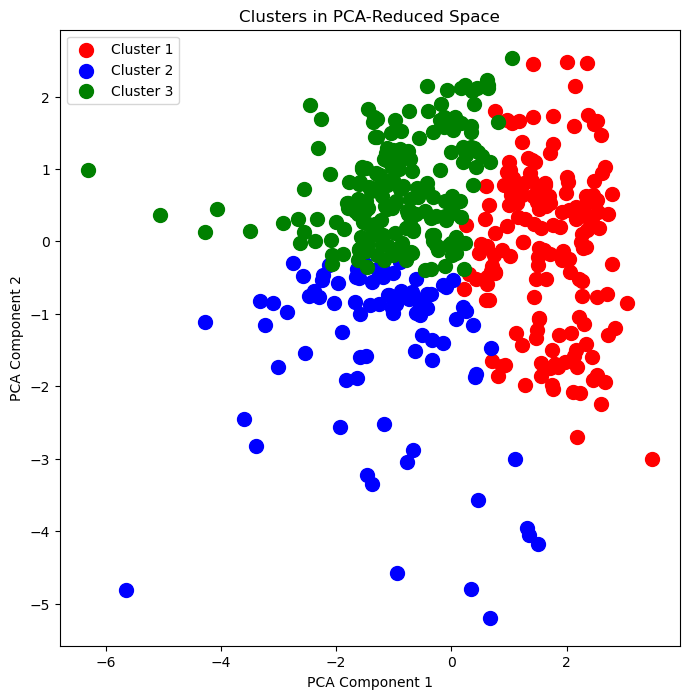

In [34]:
# Plot the K-Means clusters in the reduced PCA space

colours = ['red', 'blue', 'green']
plt.figure(figsize=(8, 8))

for i in range(3):
    plt.scatter(dataset_reduced[labels == i, 0], dataset_reduced[labels == i, 1],
                s=100, c=colours[i], label=f'Cluster {i+1}')

plt.title('Clusters in PCA-Reduced Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

In [35]:
# Display PCA components

pca_components_df = pd.DataFrame(pca.components_, columns=continuous_features, index=['Principal Component 1', 'Principal Component 2'])
pca_components_df

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Principal Component 1,-0.129618,0.539660,0.569702,-0.166421,0.550473,0.191545
Principal Component 2,0.592887,0.144904,0.019033,0.575046,-0.037312,0.543190


In [36]:
# Calculate and print the final silhouette score to assess K_Means clusters quality

silhouette_avg = silhouette_score(dataset[continuous_features], labels)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.23739854367983113


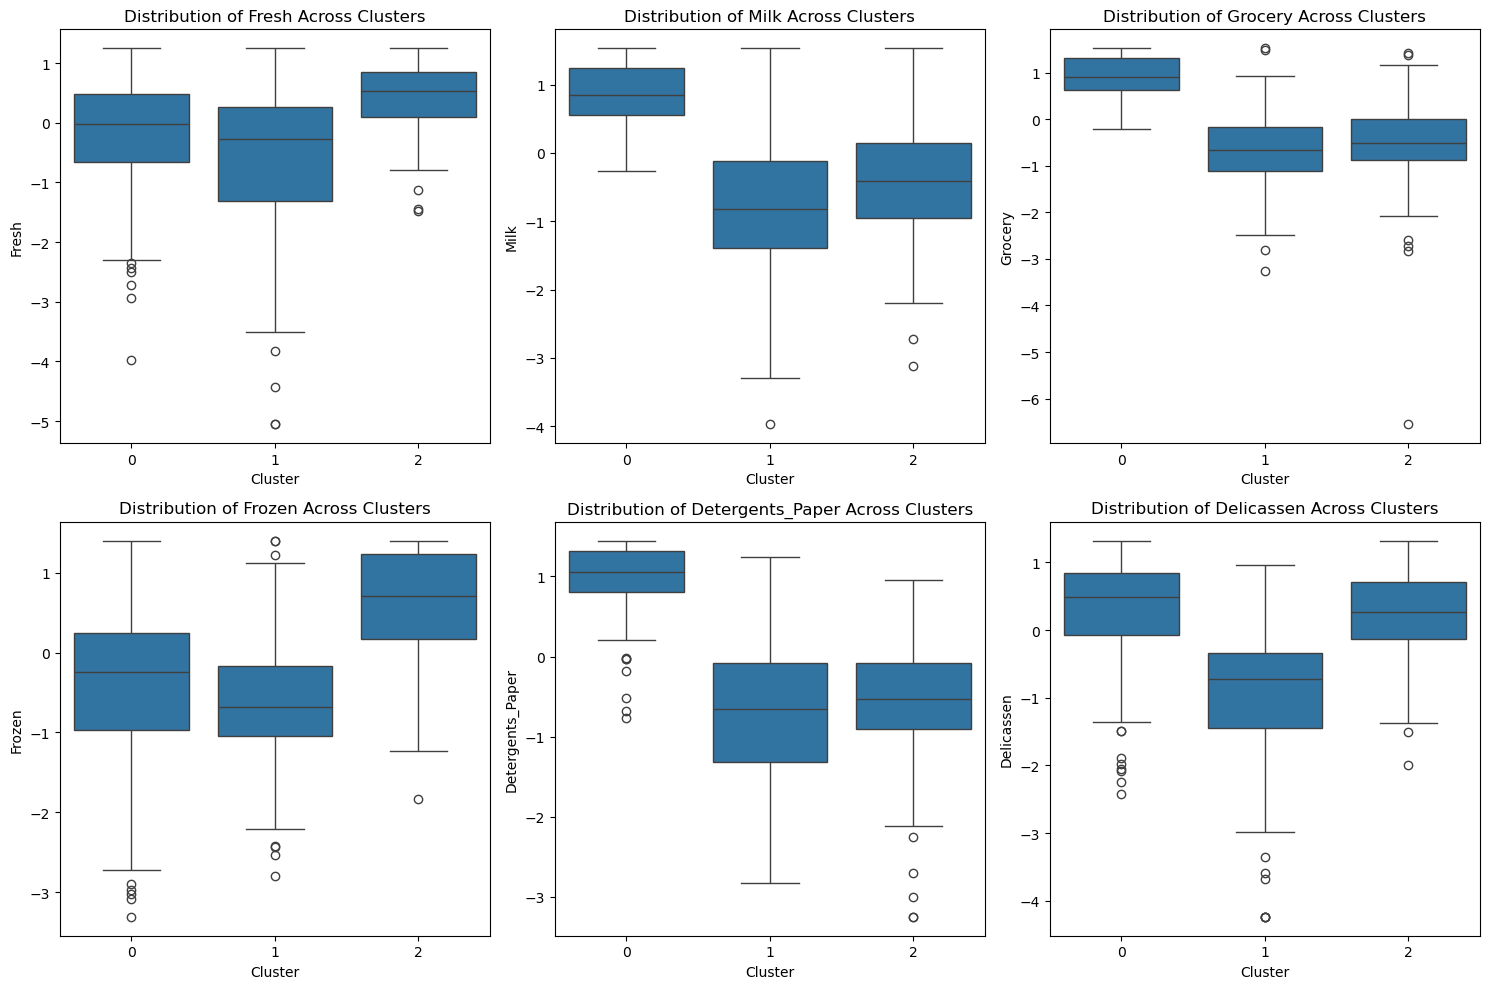

In [37]:
# Display feature distribution accross K_Means clusters

plt.figure(figsize=(15, 10))
for i, feature in enumerate(continuous_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Cluster', y=feature, data=dataset)
    plt.title(f'Distribution of {feature} Across Clusters')
plt.tight_layout()
plt.show()

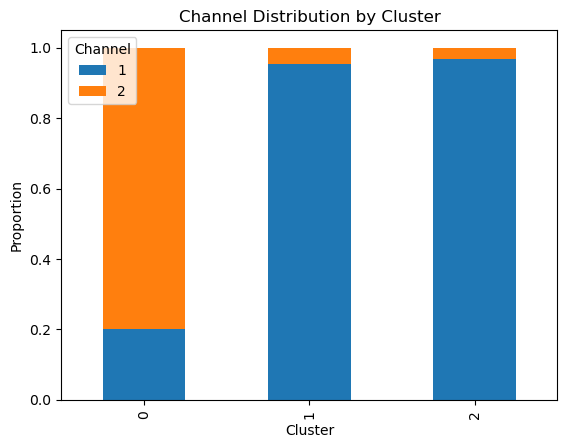

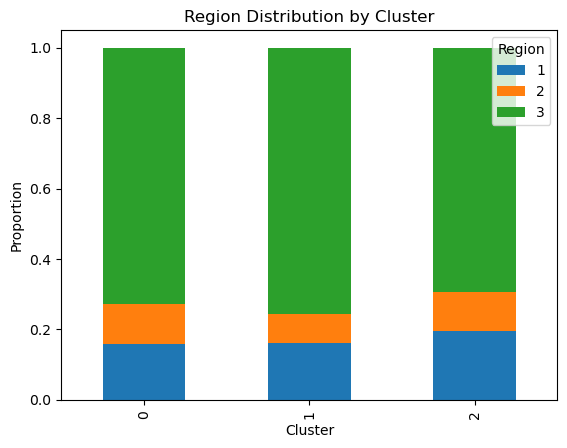

In [38]:
# Proportion of categorical features within each K_Means cluster

pd.crosstab(dataset['Cluster'], dataset['Channel'], normalize='index').plot(kind='bar', stacked=True)
plt.title('Channel Distribution by Cluster')
plt.ylabel('Proportion')
plt.show()

pd.crosstab(dataset['Cluster'], dataset['Region'], normalize='index').plot(kind='bar', stacked=True)
plt.title('Region Distribution by Cluster')
plt.ylabel('Proportion')
plt.show()

## 3.2 AGGLOMERATIVE HIERARCHICAL CLUSTERING

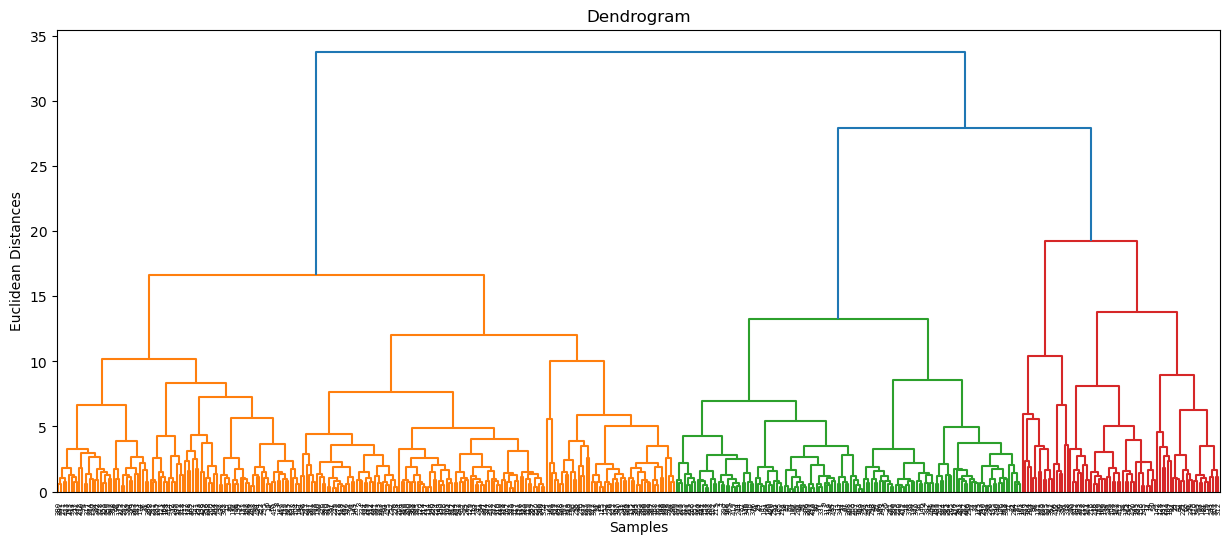

In [40]:
# Dendrogram to determine the number of clusters

plt.figure(figsize=(15, 6))
dendrogram = sch.dendrogram(sch.linkage(dataset[continuous_features], method='ward'))
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Euclidean Distances')
plt.show()

In [41]:
# Apply Agglomerative Clustering with the selected number of clusters (The Dendrogram suggests 3)

hc = AgglomerativeClustering(n_clusters=3, linkage='ward')
hc_labels = hc.fit_predict(dataset[continuous_features])

# Add Agglomerative Clustering labels to the dataset
dataset['Agglomerative Cluster'] = hc_labels

In [42]:
# Calculate and print the final silhouette score to assess Agglomerative Clustering clusters quality

silhouette_avg_agg = silhouette_score(dataset[continuous_features], hc_labels)
print(f'Silhouette Score for Agglomerative Clustering: {silhouette_avg_agg}')

Silhouette Score for Agglomerative Clustering: 0.24018511092474953


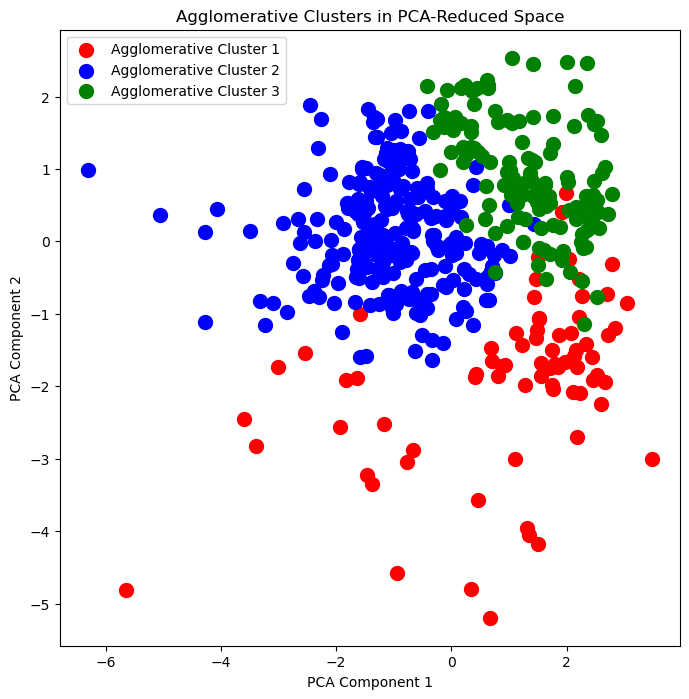

In [43]:
# Plot the Agglomerative Clustering clusters in the reduced PCA space

plt.figure(figsize=(8, 8))
for i in range(3):
    plt.scatter(dataset_reduced[hc_labels == i, 0], dataset_reduced[hc_labels == i, 1],
                s=100, c=colours[i], label=f'Agglomerative Cluster {i+1}')
plt.title('Agglomerative Clusters in PCA-Reduced Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


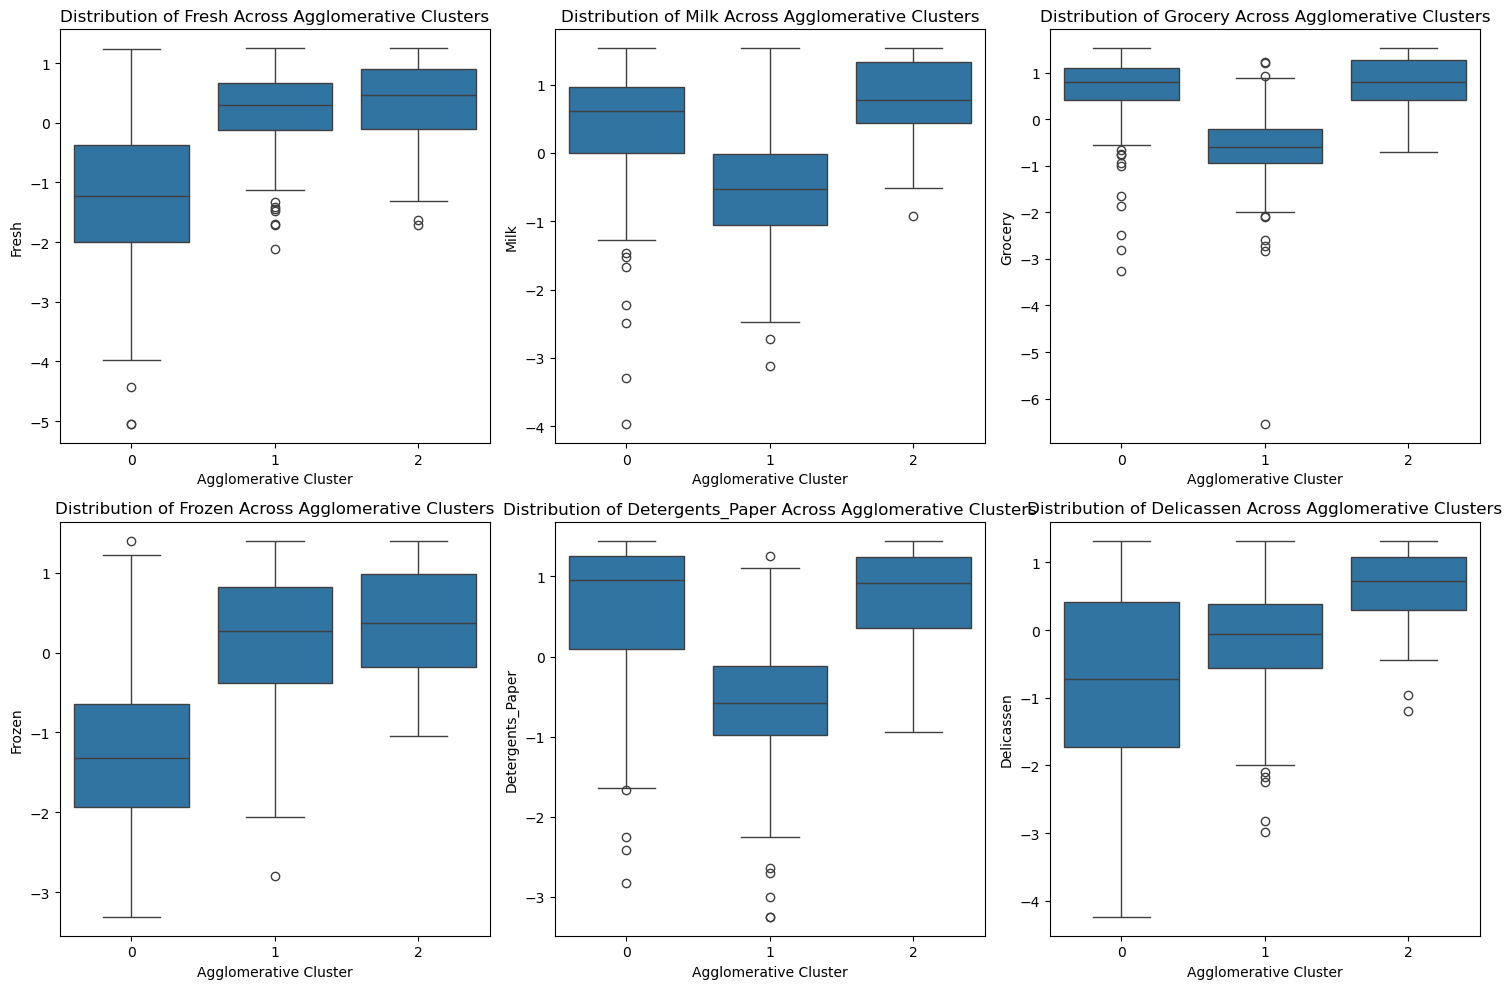

In [44]:
# Display feature distribution across clusters for Agglomerative clustering

plt.figure(figsize=(15, 10))
for i, feature in enumerate(continuous_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Agglomerative Cluster', y=feature, data=dataset)
    plt.title(f'Distribution of {feature} Across Agglomerative Clusters')
plt.tight_layout()
plt.show()

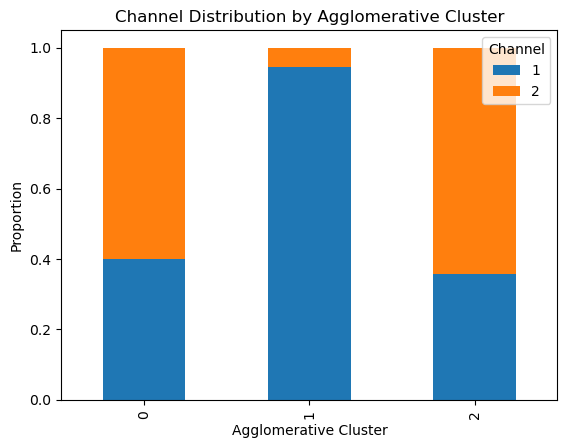

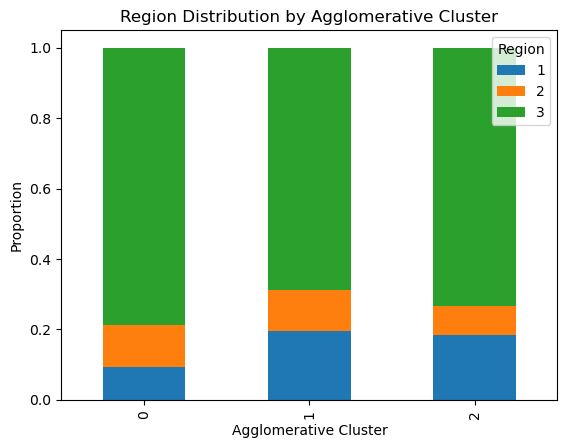

In [45]:
# Proportion of categorical features within each Agglomerative Clustering cluster

pd.crosstab(dataset['Agglomerative Cluster'], dataset['Channel'], normalize='index').plot(kind='bar', stacked=True)
plt.title('Channel Distribution by Agglomerative Cluster')
plt.ylabel('Proportion')
plt.show()

pd.crosstab(dataset['Agglomerative Cluster'], dataset['Region'], normalize='index').plot(kind='bar', stacked=True)
plt.title('Region Distribution by Agglomerative Cluster')
plt.ylabel('Proportion')
plt.show()